# Descubra as melhores notas de matemática do ENEM 2016

Você deverá criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016. 

## Tópicos

Neste desafio você aprenderá:

- Lógica
- Análise de dados
- Estatística
- Regression

## Detalhes

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Muitas universidades brasileiras utilizam o ENEM para selecionar seus futuros alunos e alunas. Isto é feito com uma média ponderada das notas das provas de matemática, ciências da natureza, linguagens e códigos, ciências humanas e redação. Determine os 20 melhores colocados, por ordem, para os pesos abaixo:

- matemática: 3
- ciências da natureza: 2
- linguagens e códigos: 1.5
- ciências humanas: 1
- redação: 3

No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna **NU_NOTA_MT**) de quem participou do ENEM 2016. 

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: **NU_INSCRICAO** e **NU_NOTA_MT**.

Faça o upload do arquivo answer.csv usando o botão "Submeter resposta".

## Observações

O objetivo do desafio é avaliar a sua capacidade de resolver problemas, então ele pode ser resolvido em qualquer linguagem de programação ou ferramenta que você tenha facilidade. Mas recomendamos o uso de linguagens com maior ferramental de matemática e estatística como Python, R, Scala ou Julia.

# Imports e carga de dados

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

## Antes de começar, vamos verificar se as colunas são iguais para os dados de treino e teste

In [131]:
dados = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

print('Treino: {}\nTeste: {}'.format(dados.shape, teste.shape))

Treino: (13730, 167)
Teste: (4576, 47)


In [132]:
dados.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=167)

In [133]:
teste.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

---

A quantidade de colunas nos dados de teste é muito inferior as de treino, para a competição não faz sentido tratar os dados que não estão no conjunto de teste, por isso serão descartados as colunas que não estão no conjunto de teste.

In [134]:
dados = dados[teste.columns]

# colunas que não estão nos dados de teste mas que serão usadas na análise
dados['TP_PRESENCA_MT'] = pd.read_csv('train.csv', usecols=['TP_PRESENCA_MT'])

dados['TARGET'] = pd.read_csv('train.csv', usecols=['NU_NOTA_MT'])

---

Com isso já podemos continuar com as análises, por enquanto serão usados os dados de treino para a criação dos modelos e definições de pré-processamento.  
Os dados de teste serão usados posteriormente para a geração das previsões para a competição.

# Análise Exploratória.
Com ela podemos compreender melhor os dados para poder tomar decisões sobre os proximos passos.

In [135]:
# primeiras linhas
dados.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,TP_PRESENCA_MT,TARGET
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,D,D,C,A,A,C,H,A,1,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,A,A,B,A,A,A,NaN,A,1,459.8
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,D,D,C,A,A,A,NaN,A,0,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,H,E,E,C,B,C,F,D,0,NaN
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,E,D,C,A,A,B,F,A,0,NaN


In [136]:
# linhas e colunas
dados.shape

(13730, 49)

In [137]:
# informações sobre os dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 49 columns):
NU_INSCRICAO              13730 non-null object
CO_UF_RESIDENCIA          13730 non-null int64
SG_UF_RESIDENCIA          13730 non-null object
NU_IDADE                  13730 non-null int64
TP_SEXO                   13730 non-null object
TP_COR_RACA               13730 non-null int64
TP_NACIONALIDADE          13730 non-null int64
TP_ST_CONCLUSAO           13730 non-null int64
TP_ANO_CONCLUIU           13730 non-null int64
TP_ESCOLA                 13730 non-null int64
TP_ENSINO                 4282 non-null float64
IN_TREINEIRO              13730 non-null int64
TP_DEPENDENCIA_ADM_ESC    4282 non-null float64
IN_BAIXA_VISAO            13730 non-null int64
IN_CEGUEIRA               13730 non-null int64
IN_SURDEZ                 13730 non-null int64
IN_DISLEXIA               13730 non-null int64
IN_DISCALCULIA            13730 non-null int64
IN_SABATISTA              13730 non-null

In [138]:
# Visão um pouco mais detalhada
print('INFORMAÇÕES SOBRE OS DADOS:\n')
for ind, i in enumerate(dados.columns):
    print('{}\t{}\tTipo: {}\tInválidos: {}\tÚnicos: {}'.format(ind,i,dados[i].dtype,dados[i].isnull().sum(),dados[i].nunique()))
    print('-' * 100)

INFORMAÇÕES SOBRE OS DADOS:

0	NU_INSCRICAO	Tipo: object	Inválidos: 0	Únicos: 13730
----------------------------------------------------------------------------------------------------
1	CO_UF_RESIDENCIA	Tipo: int64	Inválidos: 0	Únicos: 27
----------------------------------------------------------------------------------------------------
2	SG_UF_RESIDENCIA	Tipo: object	Inválidos: 0	Únicos: 27
----------------------------------------------------------------------------------------------------
3	NU_IDADE	Tipo: int64	Inválidos: 0	Únicos: 55
----------------------------------------------------------------------------------------------------
4	TP_SEXO	Tipo: object	Inválidos: 0	Únicos: 2
----------------------------------------------------------------------------------------------------
5	TP_COR_RACA	Tipo: int64	Inválidos: 0	Únicos: 6
----------------------------------------------------------------------------------------------------
6	TP_NACIONALIDADE	Tipo: int64	Inválidos: 0	Únicos: 5
---

---

Análise preliminar e levantamento de hipóteses sobre os dados:

- Colunas CO_UF_RESIDENCIA e SG_UF_RESIDENCIA posuem a mesma informação, mas com tipos diferentes de entradas.
- Colunas TP_ENSINO e TP_DEPENDENCIA_ADM_ESC possuem a mesma quantidade de valores inválidos, o que pode representar algum tipo de falha na captação das amostras dos dados por se tratar de dados referentes a escola e a quantidade de dados faltantes ser significativa (68,88%).
- Colunas TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC representam a presença em cada tipo de prova, e elas combinadas com as colunas de notas talvez possam explicar alguns dos valores faltantes dos mesmos.
- Colunas CO_PROVA_CN, CO_PROVA_CH, CO_PROVA_MT, CO_PROVA_LC, representam os diferentes tipos provas aplicadas, e para este tipo de análise estas informações talvez não sejam muito relevantes.
- Colunas NU_NOTA_COMP1 a NU_NOTA_COMP5 e TP_STATUS_REDACAO	definem o porque do candidato receber a nota final da redação.
- Colunas Q001, Q002, Q006, Q024, Q025, Q026, Q027 e Q047 pertencem ao questionário socio-econômico respondido pelo candidato, e possui informações sobre a escolaridade dos pais, se possui acesso a um computador e internet em casa e dados sobre trabalho e escola dos candidatos.

---

Antes de iniciar o pre-processamento, vamos separar em dados categoricos e numericos para facilitar as transformações e confirmar algumas hipóteses

In [139]:
# Separa em dados categóricos e numéricos para facilitar as análises
categoricos = dados[[i for i in dados.columns if(dados[i].dtype == 'object')]]
numericos = dados[[i for i in dados.columns if(dados[i].dtype != 'object')]]

In [140]:
# valores nulos dos dados categóricos
categoricos.isnull().sum()

NU_INSCRICAO           0
SG_UF_RESIDENCIA       0
TP_SEXO                0
CO_PROVA_CN            0
CO_PROVA_CH            0
CO_PROVA_LC            0
CO_PROVA_MT            0
Q001                   0
Q002                   0
Q006                   0
Q024                   0
Q025                   0
Q026                   0
Q027                7373
Q047                   0
dtype: int64

In [141]:
# Quantidade de categorias
categoricos.nunique()

NU_INSCRICAO        13730
SG_UF_RESIDENCIA       27
TP_SEXO                 2
CO_PROVA_CN            10
CO_PROVA_CH            10
CO_PROVA_LC             9
CO_PROVA_MT             9
Q001                    8
Q002                    8
Q006                   17
Q024                    5
Q025                    2
Q026                    3
Q027                   13
Q047                    5
dtype: int64

In [142]:
# valores nulos dos dados numericos
numericos.isnull().sum()

CO_UF_RESIDENCIA             0
NU_IDADE                     0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 9448
IN_TREINEIRO                 0
TP_DEPENDENCIA_ADM_ESC    9448
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
TP_LINGUA                    0
TP_STATUS_REDACAO         3597
NU_NOTA_COMP1             3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_COMP5             3597
NU_NOTA_REDACAO           3597
TP_PRESE

## Verifica a quantidade de notas inválidas com a quantidade de faltas e anulações de provas. 

In [143]:
# Verifica a quantidade de alunos com as provas anuladas ou que faltaram
len(numericos[numericos.TP_PRESENCA_CH != 1])

3389

In [144]:
# Verifica a quantidade de alunos com as provas anuladas ou que faltaram
len(numericos[numericos.TP_PRESENCA_CN != 1])

3389

In [145]:
# Verifica a quantidade de alunos com as provas anuladas ou que faltaram
len(numericos[numericos.TP_PRESENCA_LC != 1])

3597

## Verifica o valor de correlação dos dados antes dos tratamentos.

In [146]:
# verifica a correlação entre as variáveis
numericos.corr().iloc[:,-1].sort_values(ascending=False)

TARGET                    1.000000
NU_NOTA_CN                0.584941
NU_NOTA_CH                0.529594
NU_NOTA_LC                0.494695
NU_NOTA_REDACAO           0.379376
TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP5             0.343337
NU_NOTA_COMP4             0.342282
NU_NOTA_COMP2             0.335638
NU_NOTA_COMP1             0.299402
CO_UF_RESIDENCIA          0.107493
TP_ESCOLA                 0.069304
TP_ANO_CONCLUIU           0.029039
IN_DISCALCULIA            0.009813
TP_PRESENCA_CH            0.003552
TP_PRESENCA_CN            0.003552
IN_DISLEXIA               0.001453
IN_BAIXA_VISAO            0.000685
IN_GESTANTE              -0.000945
IN_IDOSO                 -0.011336
IN_SURDEZ                -0.015249
IN_SABATISTA             -0.016459
IN_TREINEIRO             -0.022287
TP_NACIONALIDADE         -0.034965
TP_STATUS_REDACAO        -0.059376
NU_IDADE                 -0.061485
TP_ENSINO                -0.086353
TP_ST_CONCLUSAO     

---

- Para que não seja perdida nenhum tipo de informação podemos criar novas categorias que irão representar os dados inválidos de algumas variáveis.
- A hipótese de que os dados inválidos das colunas de notas correspodem realmente com os mesmos candidatos que faltaram ou tiveram a prova cancelada por algum motivo.
- Tambem foi verificado quais variáveis possuem maior correlação com a variável alvo das predições, mesmo que um nível alto de correlação não implique necessáriamente causalidade, seu valor pode ser um indicativo da importancia dessa variável.

# Pré - processamento
Nesta etapa serão transformados e tratados os dados, a fim de diminuir suas inconsistências e tornar o processo de definição das variáveis do modelo (**feature selection**) mais fácil e precisa.

## Pré - processamento: Tratamento de Valores inválidos - Variáveis categóricas
Com relação aos dados categóricos, vimos acima que apenas a coluna Q027 possui dados faltantes, como a quantidade de valores é muito alta será criado uma nova categoria para que não seja necessário excluir os dados.


Como ela possui 13 categorias, representadas pelas letras A até M, a nova categoria que representará os dados não definidos será a letra **N**.

In [147]:
# Cria categoria N
categoricos.fillna('N', inplace=True)

## Pré - processamento: Tratamento de Valores inválidos  - Variáveis numéricas


As variáveis possuem dois tipos de casos específicos em seus valores inválidos:

- Os valores inválidos das colunas de **notas** correspondem ao cruzamento dos dados dos alunos que faltaram na prova ou tiveram a mesma cancelada, o que podemos concluir que faz sentido atribuir o valor 0 (zero) para elas.


- As colunas TP_ENSINO e TP_DEPENDENCIA_ADM_ESC não possuem motivos aparentes para o surgimento dos valores inválidos, o fato de serem informações referentes a escola e por possuirem a mesma quantidade de valores inválidos podem ser indicadores de que ocorreram erros na coleta dos dados. Neste caso, para que não seja desperdiçada as informações, será criada uma nova categoria para cada variável que representará os valores inválidos: TP_ENSINO receberá a categoria **4** - Indefinido e a TP_DEPENDENCIA_ADM_ESC a categoria **5** - Indefinido.


- A variável alvo (nota de matemática) possui os valores inválidos equivalentes aos alunos que não fizeram a prova, com uma diferença: o arquivo disponibilizado (teste) para que seja feita as previsões finais da competição **não** possui a coluna que define se o aluno estava presente na realização da prova, o que nos faz partir do pressuposto que todos os alunos presentes no conjunto de teste estavam presentes na prova. 

In [148]:
#Cria as novas categorias
numericos['TP_ENSINO'].fillna(4,inplace=True)
numericos['TP_DEPENDENCIA_ADM_ESC'].fillna(5,inplace=True)
numericos['TP_STATUS_REDACAO'].fillna(10, inplace=True)


In [149]:
# seta os valores 0 das notas
numericos.fillna(0,inplace=True)


---

Com isso eliminamos os valores inválidos.  
O próximo passo é diminuir a quantidade de categorias para a criação das variávies dummies

## Pré - processamento: Diminuição de dimensionalidade
Podemos diminuir as colunas TP_PRESENCA_LC, TP_PRESENCA_CH, TP_PRESENCA_CN para apenas 2:
- 0 - Faltou a prova
- 1 - Presente

A coluna TP_PRESENCA_MT não precisará ser modificada pois ela será retirada mais a frente

In [150]:
# Diminuir as categorias
for i in ['TP_PRESENCA_LC', 'TP_PRESENCA_CH', 'TP_PRESENCA_CN']:
    numericos[i] = np.where(numericos[i] != 1, 0, 1)

## Podemos verificar novamente o valor das correlações

In [151]:
# podemos verificar novamente os valores de correlação para saber se os valores foram alterados depois das transformações
numericos.corr().iloc[:,-1].sort_values(ascending=False)

TARGET                    1.000000
NU_NOTA_LC                0.943954
TP_PRESENCA_LC            0.927129
TP_PRESENCA_MT            0.923641
NU_NOTA_CN                0.907039
NU_NOTA_CH                0.903608
NU_NOTA_COMP1             0.882746
TP_PRESENCA_CH            0.879128
TP_PRESENCA_CN            0.879128
NU_NOTA_REDACAO           0.875929
NU_NOTA_COMP4             0.866827
NU_NOTA_COMP2             0.862709
NU_NOTA_COMP3             0.854946
NU_NOTA_COMP5             0.722275
TP_ESCOLA                 0.189084
IN_TREINEIRO              0.078804
TP_ST_CONCLUSAO           0.023736
IN_DISCALCULIA            0.008392
IN_DISLEXIA               0.005259
CO_UF_RESIDENCIA          0.002613
IN_SABATISTA             -0.002457
IN_SURDEZ                -0.002617
IN_BAIXA_VISAO           -0.006546
IN_IDOSO                 -0.009061
IN_GESTANTE              -0.028129
TP_NACIONALIDADE         -0.033130
TP_COR_RACA              -0.070239
TP_DEPENDENCIA_ADM_ESC   -0.109590
TP_LINGUA           

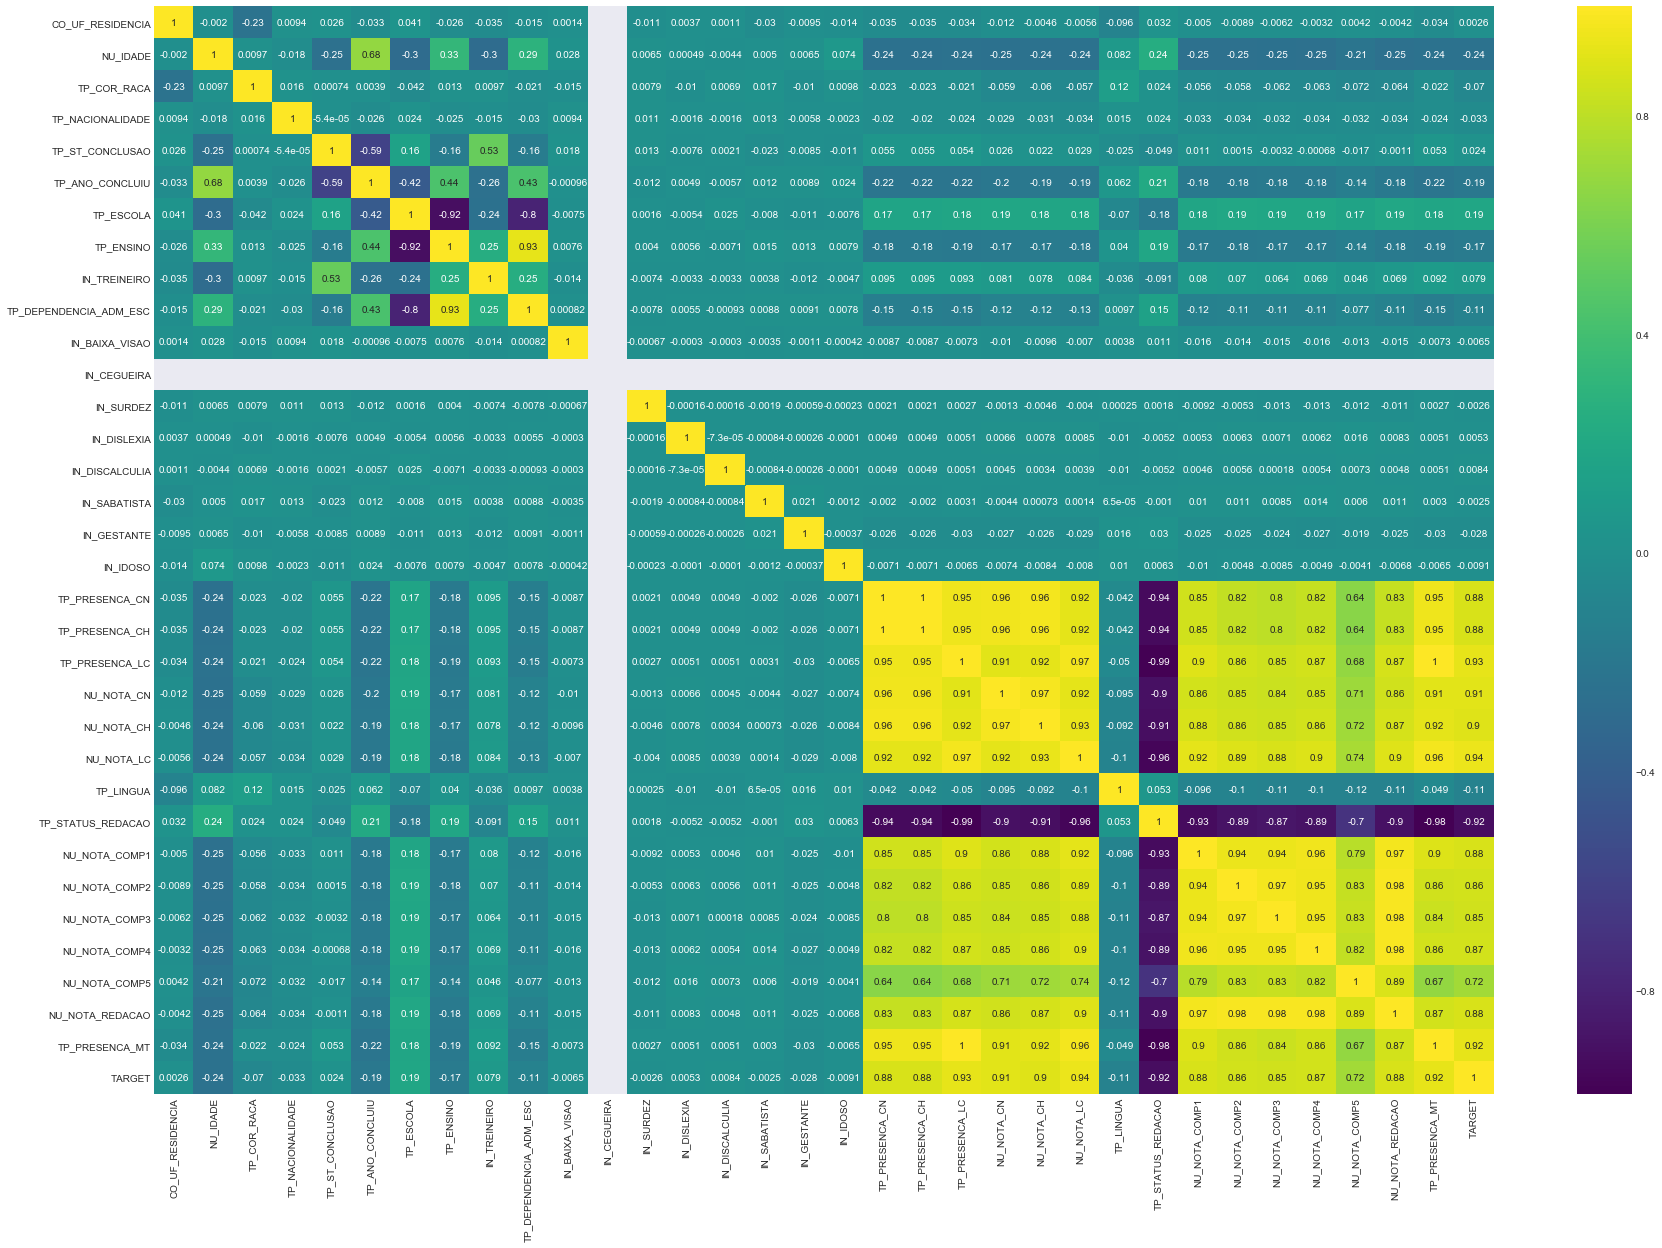

In [152]:
plt.figure(figsize=(30,20))
sns.set_style('darkgrid')
sns.heatmap(numericos.corr(), annot=True, cmap='viridis')

---

Com isso podemos ver algumas coisas interessantes:
- As notas das provas continuam sendo as variáveis com as maiores correlações positivas.
- É possivel ver outras variáveis com seus respectivos valores de correlação alterados, como é o caso da TP_STATUS_REDACAO.

## Pré - processamento: Reorganizando os dados em um dataframe único novamente

In [153]:
dados = pd.concat((categoricos,numericos), axis=1)

# Retirar a coluna que não será usada
dados.drop('TP_PRESENCA_MT', inplace=True, axis=1)

In [154]:
# Salva os dados processados
dados.to_csv('dados_limpos.csv', index=False)


---

Com isso temos os dados totalmente limpos e prontos para receberem os processos de feature selection ou tratamentos específicos para algum tipo de algoritmo.

## Limpeza dos dados de teste

In [155]:
categoricos = teste[[i for i in teste.columns if(teste[i].dtype == 'object')]]
numericos = teste[[i for i in teste.columns if(teste[i].dtype != 'object')]]

# Cria categoria N
categoricos.fillna('N', inplace=True)

#Cria as novas categorias
numericos['TP_ENSINO'].fillna(4,inplace=True)
numericos['TP_DEPENDENCIA_ADM_ESC'].fillna(5,inplace=True)
numericos['TP_STATUS_REDACAO'].fillna(10, inplace=True)


# seta os valores 0 das notas
numericos.fillna(0,inplace=True)


# Diminuir as categorias
for i in ['TP_PRESENCA_LC', 'TP_PRESENCA_CH', 'TP_PRESENCA_CN']:
    numericos[i] = np.where(numericos[i] != 1, 0, 1)

    
teste = pd.concat((categoricos,numericos), axis=1)

# Salva os dados processados
teste.to_csv('teste_limpo.csv', index=False)


# Feature Selection
Nem sempre utilizar todas as variáveis é a melhor opção para o treinamento de um modelo, o excesso de variáveis pode afetar a previsão do modelo e impactar negativamente em sua performance.  
Para o modelo escolhido será usado:

 - NU_NOTA_CN
 - NU_NOTA_CH
 - NU_NOTA_LC
 - NU_NOTA_REDACAO
 - NU_NOTA_PONDERADA - Criada atribuindo pesos diferentes as notas anteriores

# Preparando os dados para o modelo

In [156]:
dados = pd.read_csv('dados_limpos.csv')
teste = pd.read_csv('teste_limpo.csv')
target = dados['TARGET']

notas = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']

dados = dados[notas]
teste = teste[notas]


## Gerando a nova coluna

In [157]:
# Usada para a média ponderada
def media_ponderada(col):
    '''Função que define a média ponderada, aplicando os pesos correspondentes, passados pela competição.
    
    inputs:
    col - Valores das colunas NU_NOTA_CN , NU_NOTA_CH, NU_NOTA_LC ,NU_NOTA_REDACAO
    
    output:
    Retorna o cálculo da média ponderada.
    
    '''
    
    return ((col[0] * 2) + col[1] + (col[2] * 1.5) + (col[3] * 3))/ 7.5



dados['NU_NOTA_PONDERADA'] = dados[notas].apply(media_ponderada, axis=1)
teste['NU_NOTA_PONDERADA'] = teste[notas].apply(media_ponderada, axis=1)



# Escalonando os dados para a rede neural

In [158]:
# Escalonamento

# Treino

scaler_x = StandardScaler()
x = scaler_x.fit_transform(dados) 


scaler_y = StandardScaler()
y = target.values
y = scaler_y.fit_transform(y.reshape(-1,1))
y = y.ravel()


# Teste
teste = scaler_x.transform(teste)

In [165]:
x.shape

(13730, 5)

## Treinamento do modelo

In [184]:
x_train, x_test,y_train, y_test = train_test_split(x,y, test_size=0.3)


mlp_model = MLPRegressor(hidden_layer_sizes=(3077), 
                        verbose=True,
                        max_iter=1000,
                        tol=0.000001,)

mlp_model.fit(x_train, y_train)

mlp_predict = mlp_model.predict(x_test)


Iteration 1, loss = 0.09041802
Iteration 2, loss = 0.04355534
Iteration 3, loss = 0.04142694
Iteration 4, loss = 0.04042104
Iteration 5, loss = 0.04003016
Iteration 6, loss = 0.04044390
Iteration 7, loss = 0.03957538
Iteration 8, loss = 0.03974884
Iteration 9, loss = 0.03922691
Iteration 10, loss = 0.03921894
Iteration 11, loss = 0.03974757
Iteration 12, loss = 0.03898316
Iteration 13, loss = 0.03897182
Iteration 14, loss = 0.03944522
Iteration 15, loss = 0.04046617
Iteration 16, loss = 0.03894418
Iteration 17, loss = 0.03943129
Iteration 18, loss = 0.03907731
Iteration 19, loss = 0.03887998
Iteration 20, loss = 0.03905228
Iteration 21, loss = 0.03883403
Iteration 22, loss = 0.03882859
Iteration 23, loss = 0.03904748
Iteration 24, loss = 0.03909285
Iteration 25, loss = 0.03864811
Iteration 26, loss = 0.03857921
Iteration 27, loss = 0.03877414
Iteration 28, loss = 0.03857802
Iteration 29, loss = 0.03879989
Iteration 30, loss = 0.03866550
Iteration 31, loss = 0.03861552
Training loss did

# Resultados alcançados pelo modelo

In [185]:
# métricas

print('MÉTRICAS ALCANÇADAS PELO MODELO')
print('\nMAE: {}\nMSE: {}\nRMSE: {}\nScore Treino: {}\nScore Teste: {}'.format(
    mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(mlp_predict)),
    mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(mlp_predict)),
    np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(mlp_predict))),
    mlp_model.score(x_train, y_train),
    mlp_model.score(x_test, y_test)))


MÉTRICAS ALCANÇADAS PELO MODELO

MAE: 44.455511558756044
MSE: 3953.965074681223
RMSE: 62.8805619780964
Score Treino: 0.9237536508371251
Score Teste: 0.9231286848783027


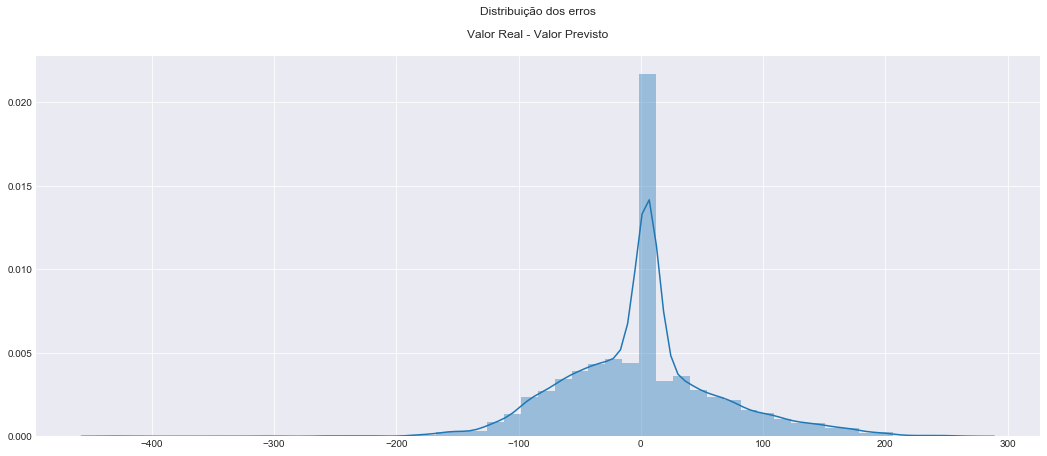

In [186]:
# Distribuição dos erros
plt.figure(figsize=(18,7))
plt.title('Distribuição dos erros\n\nValor Real - Valor Previsto\n',)
sns.distplot(scaler_y.inverse_transform(y_test) - scaler_y.inverse_transform(mlp_predict))

## Geração do arquivo com os resultados

In [187]:

resposta = pd.read_csv('test.csv', usecols=['NU_INSCRICAO'])

previsao = mlp_model.predict(teste)

resposta['NU_NOTA_MT'] = scaler_y.inverse_transform(previsao)


resposta.to_csv('answer.csv', index=False)
